# Import necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from collections import defaultdict
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms as T

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Setup Constants and Device

- Defines paths for data and metadata, and specifies selected image types.
- Sets a random seed for reproducibility.
- Selects the device (GPU if available, otherwise CPU) and prints it.


In [2]:
DATA_ROOT = '/kaggle/input/mpi-data'  
CSV_PATH = '/kaggle/input/mpi-data/patient_metadata.csv'

IMAGE_TYPES = [
    #'AC_HLA.bmp',
    #'AC_SA.bmp',
    #'AC_VLA.bmp',
    'AC_qps_rest.bmp', #1 
    #'AC_qps_reversibility.bmp',
    'AC_qps_stress.bmp', #2
    #'Rest_qgc.bmp', #3
   # 'Stress_qgc.bmp', #4 
]

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Dataset Setup and Preprocessing

- **`transform`**: Defines image preprocessing pipeline (resize, normalization).
- **`load_labels`**: Loads patient metadata from CSV.
- **`CardiacDataset`**: Custom dataset class for loading and augmenting MPI images.
  - Expands dataset for training by adding augmented versions of certain conditions.
  - Loads images, applies transformations, and stacks them into tensors.
  
- **Data Splitting**:
  - Splits dataset into training, validation, and test sets, with stratification based on condition.
  - Special handling for `Infarction` condition (small training, validation, and test subsets).

- **`train_loader`, `val_loader`, `test_loader`**: Creates DataLoader instances for training, validation, and test sets with batching and shuffling.


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [113]:
def load_labels():
    
    df = pd.read_csv(CSV_PATH)
    
    return df


class CardiacDataset(Dataset):
    def __init__(self, patient_ids, labels, data_root, image_types, transform=None, is_training=False):
        self.patient_ids = patient_ids
        self.labels = labels
        self.data_root = data_root
        self.image_types = image_types
        self.transform = transform
        self.is_training = is_training

        self.class_to_idx = {'Normal': 0, 'Ischemia': 1, 'Infarction': 2}

        # Expand dataset if training
        if self.is_training:
            self.expanded_ids = []
            self.expanded_labels = []
            for pid, label in zip(self.patient_ids, self.labels):
                repeats = 1
                if label == 'Ischemia':
                    repeats = 15 # original + 14 augmented
                elif label == 'Infarction':
                    repeats = 20  # original + 19 augmented
                for i in range(repeats):
                    self.expanded_ids.append((pid, i))  # i == 0 is original
                    self.expanded_labels.append(label)
        else:
            self.expanded_ids = [(pid, 0) for pid in self.patient_ids]
            self.expanded_labels = self.labels

    def __len__(self):
        return len(self.expanded_ids)

    def __getitem__(self, idx):
        (patient_id, aug_idx) = self.expanded_ids[idx]
        label = self.expanded_labels[idx]
        numeric_label = self.class_to_idx[label]

        image_tensors = []

        try:
            imgs_path = [
                os.path.join(self.data_root, str(patient_id), img_type)
                for img_type in self.image_types
            ]
            for img_path in imgs_path:
                image = Image.open(img_path).convert('RGB')

                if self.transform:
                    if self.is_training and aug_idx > 0:  # Only apply augmentations to clones
                        image = self.augment_image(image)
                    image = self.transform(image)

                image_tensors.append(image)

        except Exception as e:
            print(f"Error loading image for patient {patient_id}: {str(e)}")
            raise e

        images = torch.stack(image_tensors)

        return images, numeric_label, patient_id

    def augment_image(self, image):
        """Apply safe augmentations for MPI polar maps"""
        aug_transforms = transforms.Compose([
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.1, contrast=0.1)
            ], p=0.7),
    
            transforms.RandomAffine(
                degrees=0,              # no rotation
                translate=(0.05, 0.05), # small shift
                scale=(0.95, 1.05),     # small zoom
            ),
    
            transforms.RandomResizedCrop(
                size=image.size[0],     # maintain square crop
                scale=(0.95, 1.0),      # slight random zoom-in
                ratio=(1.0, 1.0)        # maintain 1:1 aspect
            )
        ])
        return aug_transforms(image)

In [114]:
df = load_labels()

df['condition'].value_counts()

condition
Normal        70
Ischemia      22
Infarction     5
Name: count, dtype: int64

In [115]:
infarction_df = df[df['condition'] == 'Infarction'].copy()
remaining_df = df[df['condition'] != 'Infarction'].copy()

infarction_train_idx = np.random.choice(infarction_df.index, 3, replace=False)
infarction_remainder = infarction_df.loc[~infarction_df.index.isin(infarction_train_idx)]
infarction_val_idx = np.random.choice(infarction_remainder.index, 1, replace=False)
infarction_test_idx = infarction_remainder.loc[~infarction_remainder.index.isin(infarction_val_idx)].index

remaining_train_val, remaining_test = train_test_split(
    remaining_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=remaining_df['condition']
)

remaining_train, remaining_val = train_test_split(
    remaining_train_val, 
    test_size=0.25, 
    random_state=42, 
    stratify=remaining_train_val['condition']
)

train_df = pd.concat([remaining_train, infarction_df.loc[infarction_train_idx]])
val_df = pd.concat([remaining_val, infarction_df.loc[infarction_val_idx]])
test_df = pd.concat([remaining_test, infarction_df.loc[infarction_test_idx]])

In [116]:
print(train_df['condition'].value_counts())
print('================================')
print(val_df['condition'].value_counts())
print('================================')
print(test_df['condition'].value_counts())

condition
Normal        41
Ischemia      13
Infarction     3
Name: count, dtype: int64
condition
Normal        15
Ischemia       4
Infarction     1
Name: count, dtype: int64
condition
Normal        14
Ischemia       5
Infarction     1
Name: count, dtype: int64


In [117]:
train_dataset = CardiacDataset(
        patient_ids=train_df['patient_id'].tolist(),
        labels=train_df['condition'].tolist(),
        data_root=DATA_ROOT,
        image_types=IMAGE_TYPES,
        transform=transform,
        is_training = True
    )

val_dataset = CardiacDataset(
        patient_ids=val_df['patient_id'].tolist(),
        labels=val_df['condition'].tolist(),
        data_root=DATA_ROOT,
        image_types=IMAGE_TYPES,
        transform=transform
    )

test_dataset = CardiacDataset(
        patient_ids=test_df['patient_id'].tolist(),
        labels=test_df['condition'].tolist(),
        data_root=DATA_ROOT,
        image_types=IMAGE_TYPES,
        transform=transform
    )

In [118]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

296
20
20


In [120]:
print(f'Images Shape: {train_dataset[0][0].shape}')

Images Shape: torch.Size([2, 3, 224, 224])


In [121]:
batch_size = 6
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Model Architecture Overview

1. **`BaseFeatureExtractor`**:
   - Utilizes **ResNet-18** as the backbone for feature extraction.
   - Removes the final classifier and average pooling layers.
   - Applies global average pooling in the forward pass to reduce feature dimensions.

2. **`AttentionModule`**:
   - Implements an attention mechanism to weight features from multiple images.
   - Computes attention scores, applies softmax, and combines features using attention weights.

3. **`MultiImageClassifier`**:
   - Combines the feature extraction and attention modules.
   - Reduces feature dimensionality after feature extraction.
   - Uses the attention module to merge features from multiple images.
   - Classifies the combined features into one of the `num_classes` (3 in this case).
   - Outputs class logits and attention weights.

In [122]:
class BaseFeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(BaseFeatureExtractor, self).__init__()
        # Use ResNet-18 as the backbone
        resnet = models.resnet18(pretrained=pretrained)
        # Remove the final classifier and avgpool layers
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        # We'll add our own adaptive pooling in forward pass
        
    def forward(self, x):
        # x shape: (batch_size, num_image_types, channels, height, width)
        batch_size, num_images, c, h, w = x.size()
        
        # Reshape to process all images
        x = x.view(-1, c, h, w)
        
        # Extract features
        features = self.features(x)  # Shape: (batch_size * num_images, 512, H, W)
        
        # Global average pooling to reduce feature dimensions
        features = F.adaptive_avg_pool2d(features, 1)  # Shape: (batch_size * num_images, 512, 1, 1)
        
        # Reshape back
        features = features.view(batch_size, num_images, -1)  # Shape: (batch_size, num_images, 512)
        
        return features


class AttentionModule(nn.Module):
    def __init__(self, feature_dim):
        super(AttentionModule, self).__init__()
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )
        
    def forward(self, features):
        # features shape: (batch_size, num_images, feature_dim)
        
        # Compute attention scores
        attention_scores = self.attention(features).squeeze(-1)  # Shape: (batch_size, num_images)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1).unsqueeze(-1)  # Shape: (batch_size, num_images, 1)
        
        # Apply attention weights to features
        weighted_features = features * attention_weights  # Shape: (batch_size, num_images, feature_dim)
        
        # Sum over images to get combined feature vector
        combined_features = weighted_features.sum(dim=1)  # Shape: (batch_size, feature_dim)
        
        return combined_features, attention_weights


class MultiImageClassifier(nn.Module):
    def __init__(self, num_classes=3, num_image_types=11, feature_dim=512):  # ResNet-18 feature dim = 512
        super(MultiImageClassifier, self).__init__()
        
        # Feature extractor
        self.feature_extractor = BaseFeatureExtractor(pretrained=True)
        
        # Feature dimensionality reduction
        self.feature_reducer = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Attention module
        self.attention = AttentionModule(256)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256, num_classes)
        )
        
    def forward(self, images):
        # images shape: (batch_size, num_image_types, channels, height, width)
        
        # Extract features from all images
        features = self.feature_extractor(images)  # Shape: (batch_size, num_image_types, 512)
        
        # Reduce feature dimensionality
        batch_size, num_images, _ = features.size()
        features = features.view(batch_size * num_images, -1)
        features = self.feature_reducer(features)
        features = features.view(batch_size, num_images, -1)  # Shape: (batch_size, num_images, 256)
        
        # Apply attention to combine features
        combined_features, attention_weights = self.attention(features)  # Shape: (batch_size, 256)
        
        # Classify combined features
        logits = self.classifier(combined_features)  # Shape: (batch_size, num_classes)
        
        return logits, attention_weights

In [123]:
model = MultiImageClassifier(num_classes=3, num_image_types=len(IMAGE_TYPES)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Class Weights and Focal Loss

1. **Class Weights Calculation**:
   - Compute inverse frequency class weights for `Normal`, `Ischemia`, and `Infarction` based on their distribution in the dataset.
   - Normalize the weights so they sum to 1.
   - Move the weights to the correct device (GPU/CPU).

2. **Focal Loss**:
   - Implements **Focal Loss** for addressing class imbalance.
   - It focuses more on hard-to-classify samples by down-weighting well-classified samples.
   - Supports optional class balancing via `alpha` and customizable focusing with `gamma`.
   - Uses `CrossEntropyLoss` with additional weighting and focusing.

In [124]:
class_counts = df['condition'].value_counts().to_dict()
total_samples = len(df)

# Raw inverse frequency weights
class_weights = {
    'Normal': total_samples / (3 * class_counts['Normal']),
    'Ischemia': total_samples / (3 * class_counts['Ischemia']),
    'Infarction': total_samples / (3 * class_counts['Infarction'])
}

# Convert to tensor
class_weight_tensor = torch.tensor([
    class_weights['Normal'],
    class_weights['Ischemia'],
    class_weights['Infarction']
], dtype=torch.float)

# Normalize so weights sum to 1
class_weight_tensor = class_weight_tensor / class_weight_tensor.sum()

# Move to device
class_weight_tensor = class_weight_tensor.to(device)

print(f"Normalized class weights: {class_weight_tensor}")

Normalized class weights: tensor([0.0550, 0.1750, 0.7700], device='cuda:0')


In [125]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, weight=None):
        """
        Args:
            alpha (float or Tensor): Class balancing factor (float for all classes, or Tensor of shape [num_classes])
            gamma (float): Focusing parameter
            weight (Tensor): Class weights for CrossEntropy (optional, usually used for imbalance)
        """
        super(FocalLoss, self).__init__()
        if isinstance(alpha, (list, torch.Tensor)):
            self.alpha = torch.tensor(alpha)
        else:
            self.alpha = alpha  # Can still be scalar
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)

        if self.alpha is not None:
            if isinstance(self.alpha, torch.Tensor):
                if self.alpha.device != inputs.device:
                    self.alpha = self.alpha.to(inputs.device)
                at = self.alpha[targets]
            else:
                at = self.alpha
            focal_loss = at * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss

        return focal_loss.mean()


# Training the Model with Early Stopping, Learning Rate Adjustment, and Class Weights

**Function**: `train_model`
This function trains a neural network model using early stopping, learning rate adjustment, and class balancing. It saves the best model based on validation loss and applies early stopping if no improvement occurs.

#### Key Components:
1. **Focal Loss**: Used for handling class imbalance in the dataset.
2. **AdamW Optimizer**: Optimizer with weight decay to help regularize the model.
3. **ReduceLROnPlateau Scheduler**: Adjusts the learning rate if validation loss plateaus.
4. **Early Stopping**: Stops training when validation loss doesn’t improve for `patience` number of epochs.

#### Parameters:
- `num_epochs=50`: Specifies the number of epochs for training.
- `learning_rate=0.0001`: Sets the initial learning rate for the AdamW optimizer.
- `class_weights=class_weight_tensor`: A tensor of class weights for handling class imbalance.
- `patience=10`: Stops training if there’s no improvement in validation loss for 10 consecutive epochs.

#### Steps:
1. **Training Phase**: 
   - The model is trained for each epoch, calculating the loss and accuracy.
   - The optimizer updates the model’s parameters using the computed gradients.

2. **Validation Phase**:
   - After each training epoch, the model is evaluated on the validation set to compute validation loss and accuracy.
   
3. **Learning Rate Adjustment**:
   - The learning rate is reduced if the validation loss plateaus.

4. **Early Stopping**:
   - If the validation loss doesn’t improve for `patience` epochs, training is stopped early to prevent overfitting.

5. **Saving Best Model**:
   - The model is saved whenever it achieves the lowest validation loss.

In [128]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, class_weights=None, patience=5):
    """
    Train a neural network model with early stopping based on validation loss.
    
    Args:
        model: The neural network model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Maximum number of training epochs
        learning_rate: Initial learning rate for the optimizer
        class_weights: Optional weights for loss function (for imbalanced classes)
        patience: Number of epochs to wait for improvement before stopping
    
    Returns:
        train_losses, train_accuracies, val_losses, val_accuracies: Lists of metrics for plotting
    """
    
    criterion = FocalLoss(alpha=class_weights, gamma=1.5)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    best_val_loss = float('inf')
    counter = 0  # For early stopping

    for epoch in range(num_epochs):
        # ---- Training phase ----
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels, _ in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # ---- Validation phase ----
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs, _ = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}')

        # ---- Learning rate adjustment ----
        scheduler.step(epoch_val_loss)

        # ---- Save best model (based on validation loss) ----
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'✅ Saved new best model at epoch {epoch+1}')
            counter = 0  # Reset counter if improvement
        else:
            counter += 1
            print(f'⏳ EarlyStopping counter: {counter} / {patience}')
            if counter >= patience:
                print(f'⛔ Early stopping triggered after {epoch+1} epochs')
                break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [129]:
num_epochs = 50
learning_rate = 0.0001

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        class_weights=class_weight_tensor,
        patience = 10
    )

<ipython-input-125-0c0d9884c7c0>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha = torch.tensor(alpha)


Epoch 1/50 | Train Loss: 0.0042, Acc: 0.9628 | Val Loss: 0.0263, Acc: 0.6500
✅ Saved new best model at epoch 1
Epoch 2/50 | Train Loss: 0.0057, Acc: 0.9459 | Val Loss: 0.0101, Acc: 0.9000
✅ Saved new best model at epoch 2
Epoch 3/50 | Train Loss: 0.0240, Acc: 0.9493 | Val Loss: 0.0266, Acc: 0.8000
⏳ EarlyStopping counter: 1 / 10
Epoch 4/50 | Train Loss: 0.0108, Acc: 0.9459 | Val Loss: 0.0106, Acc: 0.9500
⏳ EarlyStopping counter: 2 / 10
Epoch 5/50 | Train Loss: 0.0019, Acc: 0.9831 | Val Loss: 0.0081, Acc: 0.9000
✅ Saved new best model at epoch 5
Epoch 6/50 | Train Loss: 0.0011, Acc: 0.9932 | Val Loss: 0.0090, Acc: 0.9000
⏳ EarlyStopping counter: 1 / 10
Epoch 7/50 | Train Loss: 0.0013, Acc: 0.9899 | Val Loss: 0.0064, Acc: 0.9500
✅ Saved new best model at epoch 7
Epoch 8/50 | Train Loss: 0.0009, Acc: 0.9966 | Val Loss: 0.0081, Acc: 0.9000
⏳ EarlyStopping counter: 1 / 10
Epoch 9/50 | Train Loss: 0.0031, Acc: 0.9831 | Val Loss: 0.0089, Acc: 0.9000
⏳ EarlyStopping counter: 2 / 10
Epoch 10/50

In [130]:
model.load_state_dict(torch.load('best_model.pth'))

<ipython-input-130-97ca0473330f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [131]:
target_names = ['Normal', 'Ischemia', 'Infarction']

# Visualizing Average Attention Weights

The code extracts and averages the attention weights for each class on the test set, then plots them.

1. **Model Evaluation**: Set model to `eval()` and extract attention weights.
2. **Class-wise Attention**: Accumulate attention weights and compute averages per class.
3. **Plotting**: Display bar charts showing attention weights across image types for each class.

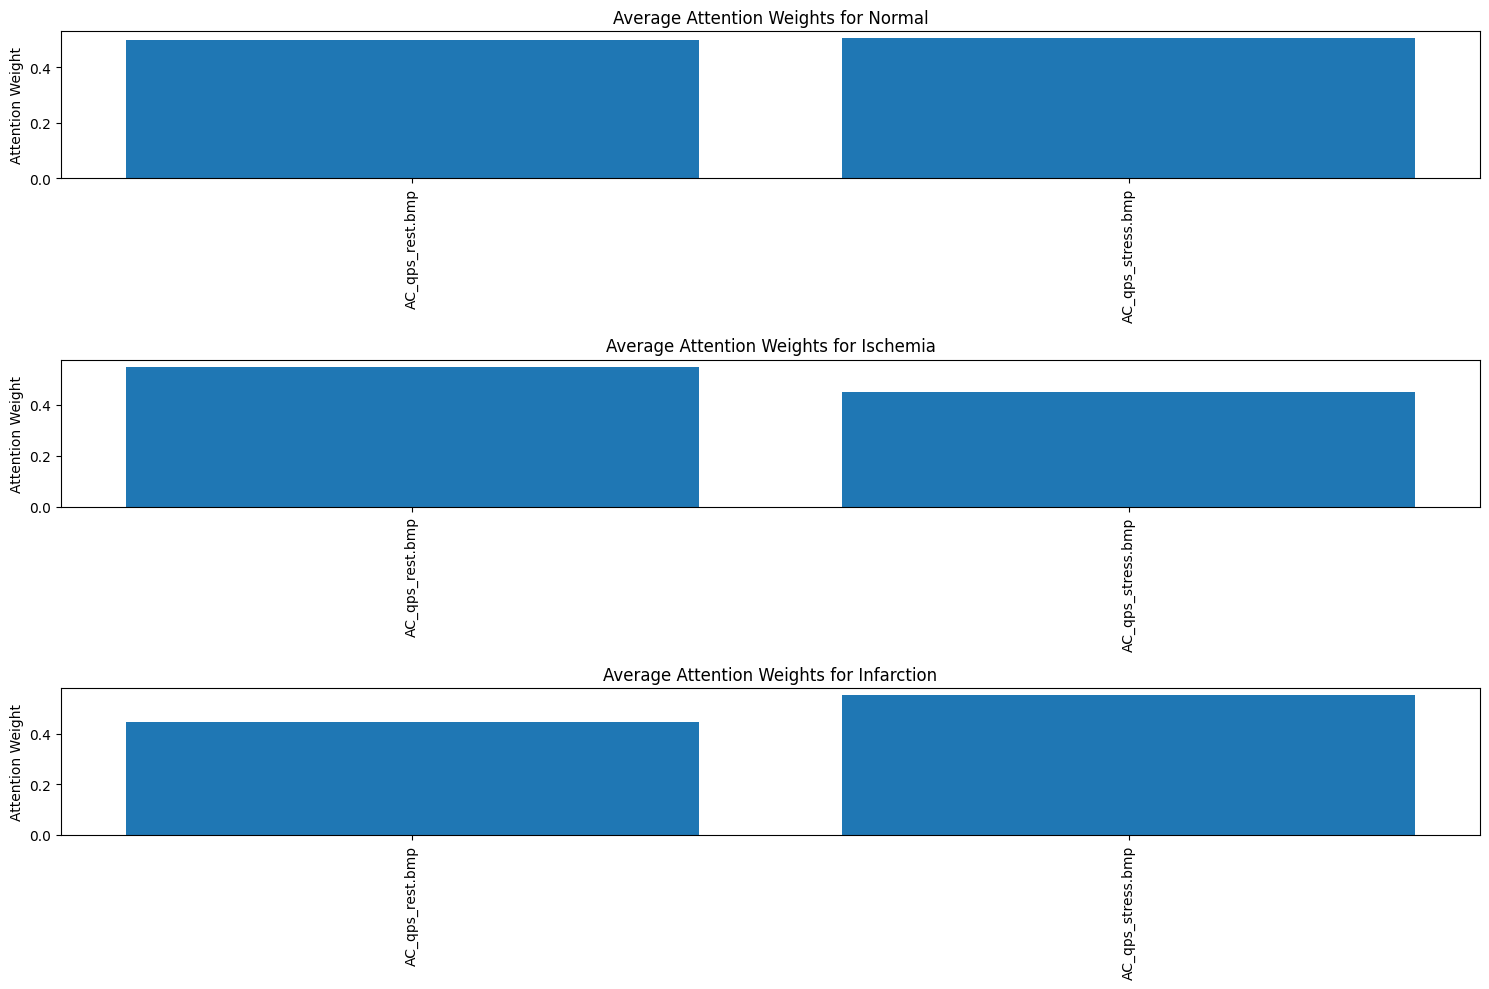

In [132]:
model.eval()

# Dictionary to store average attention weights for each class
class_attention = defaultdict(lambda: np.zeros(len(IMAGE_TYPES)))
class_counts = defaultdict(int)

with torch.no_grad():
    for images, labels, patient_ids in test_loader:
        images = images.to(device)

        # Forward pass to get attention weights
        _, attention_weights = model(images)

        # Convert attention weights to numpy
        attn_np = attention_weights.squeeze(-1).cpu().numpy()

        # Update class-specific attention weights
        for i, label in enumerate(labels.cpu().numpy()):
            class_name = target_names[label]
            class_attention[class_name] += attn_np[i]
            class_counts[class_name] += 1

# Average the attention weights for each class
for class_name in class_attention:
    if class_counts[class_name] > 0:
        class_attention[class_name] /= class_counts[class_name]

# Plot attention weights for each class
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(target_names):
    if class_name in class_attention:
        plt.subplot(len(target_names), 1, i + 1)
        plt.bar(IMAGE_TYPES, class_attention[class_name])
        plt.title(f'Average Attention Weights for {class_name}')
        plt.xticks(rotation=90)
        plt.ylabel('Attention Weight')

plt.tight_layout()
plt.show()

# Model Evaluation

- **Test Accuracy**: Calculates overall accuracy.
- **Classification Report**: Precision, recall, and F1-score per class.
- **Confusion Matrix**: Visualizes performance across classes.


In [133]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, _ in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Accuracy: 0.8500

Test Classification Report:
              precision    recall  f1-score   support

      Normal       0.87      0.93      0.90        14
    Ischemia       0.75      0.60      0.67         5
  Infarction       1.00      1.00      1.00         1

    accuracy                           0.85        20
   macro avg       0.87      0.84      0.85        20
weighted avg       0.84      0.85      0.84        20



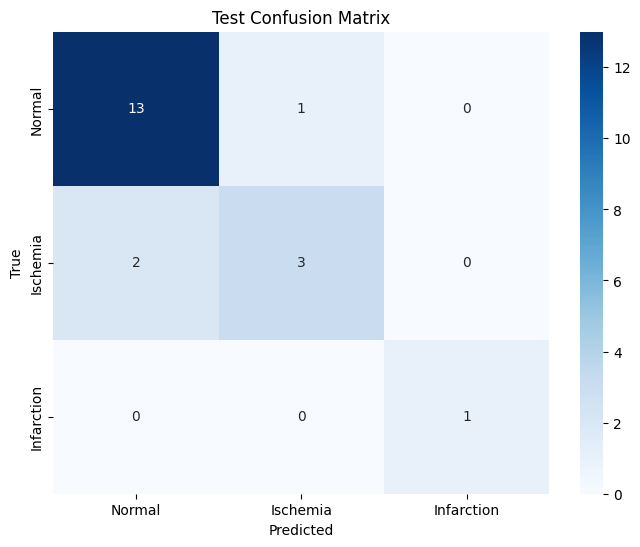

In [134]:
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report for test set
print("\nTest Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Plot confusion matrix for test set
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()